# Lab 05 Logistic Classification(Regression) - Eager Execution
* Logistic Classfication은 True or False와 같은 Binary나 복수개의 다항 분류에 쓰입니다 (Bernoulli Distribution)

### 기본 Library 선언 및 Tensorflow 버전 확인

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777)  # for reproducibility
print(tf.__version__)

2.3.0


### 강의에 설명할 Data입니다
* x_data가 2차원 배열이기에 2차원 공간에 표현하여 x1과 x2를 기준으로 y_data 0과 1로 구분하는 예제입니다
* Logistic Classification 통해 보라색과 노란색 y_data(Label)을 구분해 보겠습니다.
* Test 데이터는 붉은색의 위치와 같이 추론시 1의 값을 가지게 됩니다.

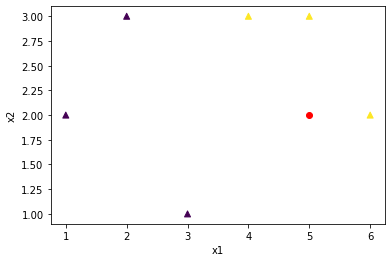

In [ ]:
x_train = [[1., 2.],
          [2., 3.],
          [3., 1.],
          [4., 3.],
          [5., 3.],
          [6., 2.]]
y_train = [[0.],
          [0.],
          [0.],
          [1.],
          [1.],
          [1.]]

x_test = [[5.,2.]]
y_test = [[1.]]

x1 = [x[0] for x in x_train]
x2 = [x[1] for x in x_train]

colors = [int(y[0] % 3) for y in y_train]
plt.scatter(x1,x2, c=colors , marker='^')
plt.scatter(x_test[0][0],x_test[0][1], c="red")

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

##  Tensorflow 2
### 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
* Tensorflow data API를 통해 학습시킬 값들을 담는다 (Batch Size는 한번에 학습시킬 Size로 정한다)
* features, labels는 실제 학습에 쓰일 Data (연산을 위해 Type를 맞춰준다)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train))

In [ ]:
dataset

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>

In [ ]:
for step in range(1):
    for features, labels  in iter(dataset):
      print(features, labels)


tf.Tensor(
[[1. 2.]
 [2. 3.]
 [3. 1.]
 [4. 3.]
 [5. 3.]
 [6. 2.]], shape=(6, 2), dtype=float32) tf.Tensor(
[[0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(6, 1), dtype=float32)


### 위 Data를 기준으로 가설의 검증을 통해 Logistic Classification 모델을 만들도록 하겠습니다
* W와 b은 학습을 통해 생성되는 모델에 쓰이는 Wegith와 Bias (초기값을 variable : 0이나 Random값으로 가능 tf.random_normal([2, 1]) )

In [ ]:
W = tf.Variable(tf.zeros([2,1]), name='weight')
b = tf.Variable(tf.zeros([1]), name='bias')

### Sigmoid 함수를 가설로 선언합니다
* Sigmoid는 아래 그래프와 같이 0과 1의 값만을 리턴합니다 tf.sigmoid(tf.matmul(X, W) + b)와 같습니다

$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [ ]:
def logistic_regression(features):
    hypothesis  = tf.divide(1., 1. + tf.exp(tf.matmul(features, W) + b))
    return hypothesis

### 가설을 검증할 Cost 함수를 정의합니다
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 위 두수식을 합치면 아래과 같습니다
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [ ]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(logistic_regression(features)) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

# optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

### 추론한 값은 0.5를 기준(Sigmoid 그래프 참조)로 0과 1의 값을 리턴합니다.
* Sigmoid 함수를 통해 예측값이 0.5보다 크면 1을 반환하고 0.5보다 작으면 0으로 반환합니다.
* 가설을 통해 실재 값과 비교한 정확도를 측정합니다.

![sigmoid](https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg)

In [ ]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

### GradientTape를 통해 경사값을 계산합니다.

In [ ]:
def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features),features,labels)
    return tape.gradient(loss_value, [W,b])

### 학습을 실행합니다.
* 위의 Data를 Cost함수를 통해 학습시킨 후 모델을 생성합니다. 
* 새로운 Data를 통한 검증 수행 [5,2]의 Data로 테스트 수행 (그래프상 1이 나와야 정상입니다)

In [ ]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels  in iter(dataset):
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads,[W,b]))
        if step % 100 == 0:
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(logistic_regression(features),features,labels)))
test_acc = accuracy_fn(logistic_regression(x_test),y_test)
print("Testset Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.6874
Iter: 100, Loss: 0.5776
Iter: 200, Loss: 0.5349
Iter: 300, Loss: 0.5054
Iter: 400, Loss: 0.4838
Iter: 500, Loss: 0.4671
Iter: 600, Loss: 0.4535
Iter: 700, Loss: 0.4420
Iter: 800, Loss: 0.4319
Iter: 900, Loss: 0.4228
Iter: 1000, Loss: 0.4144
Testset Accuracy: 1.0000
